In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
img_size=200
np.random.seed(1234567)
#loading data and fitting follows:
X_train=np.loadtxt('training_data/Xtrain_av_raw200_2_2d0_v2.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_av_raw200_2_2d0_v2.csv',delimiter=',')
#Xtrain=Xtrain[:2000]
#X_train=np.transpose(X_train)
print(X_train.shape,Y_train.shape)


(7180, 200) (7180, 2)


In [6]:
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
X_train = np.array([np.convolve(X_train[i], kernel, mode='same') for i in range(len(X_train))])
#X_test = [np.convolve(X_test[i], kernel, mode='same') for i in range(len(X_test))]
#X_train=preprocessing.normalize(X_train)
#scalar=preprocessing.StandardScaler()
#scalar.fit(X_train)
#X_train=scalar.transform(X_train)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size=0.2)
print(Xtrain.shape,Xtest.shape)

(5744, 200) (1436, 200)


In [8]:

print(np.asarray(Xtrain).shape)

Xtrain=np.asarray(Xtrain).reshape(5744, img_size, 1)
print(np.asarray(Xtrain).shape)
#Xtrain=np.array(Xtrain)

(5744, 200)
(5744, 200, 1)


In [9]:
#defining a sampling function: returns a random sample from a mean and variance
#that is input to it

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = keras.backend.random_normal(shape=keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [10]:
from keras import backend as K
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [16]:
#model defined here
#leaky reLU has been added as a separate layer than define as an activation
inp = keras.layers.Input(shape=(img_size, 1), name="encoder_input")
x1 = keras.layers.Conv1D(filters=1, kernel_size=3, padding="same", strides=1,name="encoder_conv_1", activation="tanh")(inp)
x1 = keras.layers.BatchNormalization(name="encoder_norm_1")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(x1)
x1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", strides=2, name="encoder_conv_2",activation="tanh")(x1)
x1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", strides=1, name="encoder_conv_2_sec",activation="tanh")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_2")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(x1)
x1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=1, name="encoder_conv_3", activation="tanh")(x1)
x1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=1, name="encoder_conv_3_sec", activation="tanh")(x1)
x1 = keras.layers.BatchNormalization(name="encoder_norm_3")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(x1)
x1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=1, name="encoder_conv_4", activation="tanh")(x1)
x1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=1, name="encoder_conv_4_sec", activation="tanh")(x1)
#x1 = keras.layers.BatchNormalization(name="encoder_norm_4")(x1)
#x1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_3")(x1)
#x1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", strides=1, name="encoder_conv_5", activation="tanh")(x1)
bp_lay_1 = keras.layers.BatchNormalization(name="encoder_norm_5")(x1)
#bp_lay_1 = keras.layers.LeakyReLU(name="encoder_leakyrelu_4")(x1)

#flatten the layers in encoder
shape_before_flatten = keras.backend.int_shape(bp_lay_1)[1:]
aft_flat = keras.layers.Flatten(name="flat_1")(bp_lay_1)

latent_space_dim = 64
#declare a mean and variance for the distribution
encoder_mu = keras.layers.Dense(units=latent_space_dim, name="encoder_mu",activity_regularizer=keras.regularizers.l1(10e-5))(aft_flat)
encoder_log_variance = keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(aft_flat)
encoder_op = keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

#decoder starts here
x3 = keras.layers.Dense(units=np.prod(shape_before_flatten), activation="tanh",name="decoder_dense_1")(encoder_op)
x3 = keras.layers.Reshape(target_shape=shape_before_flatten)(x3)

#x3 = keras.layers.Conv1DTranspose(filters=128, kernel_size=3, padding="same", strides=1, activation="tanh", name="decoder_conv_tran_1")(x3)
#x3 = keras.layers.BatchNormalization(name="decoder_norm_1")(x3)

x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="tanh", name="decoder_conv_tran_2")(x3)
x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=1, activation="tanh", name="decoder_conv_tran_2_sec")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_2")(x3)
#x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(x3)

x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=1, activation="tanh",name="decoder_conv_tran_3")(x3)
x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=1, activation="tanh",name="decoder_conv_tran_3_sec")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_3")(x3)
#x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(x3)

x3 = keras.layers.Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=1, activation="tanh", name="decoder_conv_tran_4")(x3)
x3 = keras.layers.Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation="tanh", name="decoder_conv_tran_4_sec")(x3)
x3 = keras.layers.BatchNormalization(name="decoder_norm_4")(x3)
#x3 = keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(x3)

decoder_output = keras.layers.Conv1DTranspose(filters=1, kernel_size=3, padding="same", strides=1,activation='tanh', name="decoder_op_layer")(x3)


In [17]:
autoencoder = keras.models.Model(inp,outputs=decoder_output, name="enc_dec")

autoencoder.summary()

autoencoder.compile(loss=loss_func(encoder_mu, encoder_log_variance),optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005))

Model: "enc_dec"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv1D)         (None, 200, 1)       4           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 200, 1)       4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv1D)         (None, 100, 16)      64          encoder_norm_1[0][0]             
____________________________________________________________________________________________

In [26]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#history=vae.fit(Xtrain, Xtrain, epochs=20, batch_size=64 ,verbose=1, validation_split=0.3)
loops=12
authist=autoencoder.fit(Xtrain, Xtrain, epochs=40, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2,callbacks=[es_callback])
''' 
temp=Xtrain
for i in range(0,loops):
    autoencoder.fit(temp, Xtrain, epochs=10, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)
    ypred=autoencoder.predict(Xtrain)
    #autoencoder.fit(ypred,Xtrain,  epochs=5, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)
    temp=ypred'''

Epoch 1/40
72/72 [==============================] - 5s 72ms/step - loss: 0.0558 - val_loss: 0.0598
Epoch 2/40
72/72 [==============================] - 5s 70ms/step - loss: 0.0549 - val_loss: 0.0583
Epoch 3/40
72/72 [==============================] - 5s 71ms/step - loss: 0.0542 - val_loss: 0.0564
Epoch 4/40
72/72 [==============================] - 5s 70ms/step - loss: 0.0558 - val_loss: 0.0555
Epoch 5/40
72/72 [==============================] - 5s 71ms/step - loss: 0.0528 - val_loss: 0.0580
Epoch 6/40
72/72 [==============================] - 5s 71ms/step - loss: 0.0525 - val_loss: 0.0542
Epoch 7/40
72/72 [==============================] - 5s 70ms/step - loss: 0.0510 - val_loss: 0.0523
Epoch 8/40
72/72 [==============================] - 5s 67ms/step - loss: 0.0512 - val_loss: 0.0540
Epoch 9/40
72/72 [==============================] - 5s 67ms/step - loss: 0.0501 - val_loss: 0.0517
Epoch 10/40
72/72 [==============================] - 5s 67ms/step - loss: 0.0495 - val_loss: 0.0510
Epoch 11/

' \ntemp=Xtrain\nfor i in range(0,loops):\n    autoencoder.fit(temp, Xtrain, epochs=10, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)\n    ypred=autoencoder.predict(Xtrain)\n    #autoencoder.fit(ypred,Xtrain,  epochs=5, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)\n    temp=ypred'

IndexError: index 5 is out of bounds for axis 0 with size 5

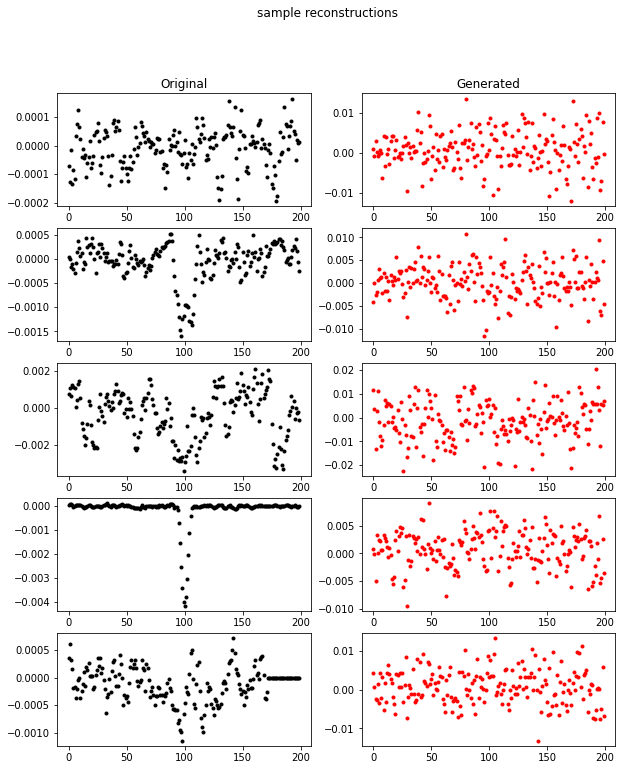

In [30]:
Ypred=autoencoder.predict(Xtest)
fig,ax=plt.subplots(5,2,figsize=(10,12))
plt.style.use('seaborn-bright')
plt.suptitle('sample reconstructions')
ar=np.random.randint(0,len(Xtest),size=10)
ax[0][0].set_title('Original')
ax[0][1].set_title('Generated')
p=0
for i in range(0,60):
    if(Ytest[i][0]==1):
        ax[p][0].plot(Xtest[ar[i]],color='black',ls='None',marker='.')
        ax[p][1].plot(Ypred[ar[i]],color='red',ls='None',marker='.')
        p+=1
ax[4][0].set_xlabel('Phase')
ax[4][1].set_xlabel('Phase')

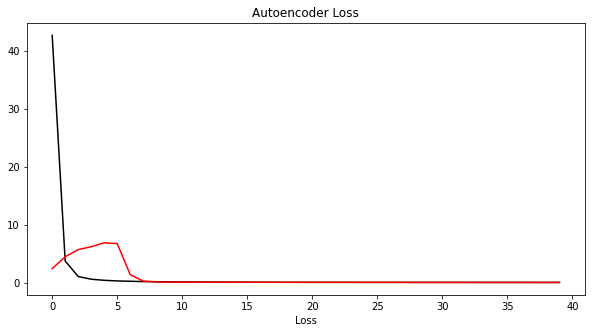

In [21]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(10,5))
plt.style.use("seaborn-bright")

ax.plot(authist.history['loss'], label='loss',color="black")
ax.plot(authist.history['val_loss'], label = 'val_loss',color="red")
ax.set_xlabel('Epoch')
ax.set_xlabel('Loss')
ax.set_title('Autoencoder Loss')
#plt.savefig('present_aut_loss.png')
plt.show()

In [19]:
print(encoder_log_variance,encoder_mu)

KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='encoder_log_variance/BiasAdd:0', description="created by layer 'encoder_log_variance'") KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='encoder_mu/BiasAdd:0', description="created by layer 'encoder_mu'")


In [31]:
x3 = keras.layers.concatenate([encoder_mu, encoder_log_variance],name='combine_layer')
x3 = keras.layers.Dense(16, activation='tanh',name='class_lay_1')(x3)
x3 = keras.layers.Dense(8, activation='tanh',name='class_lay_2')(x3)
class_out = keras.layers.Dense(2, activation='sigmoid',name='class_op_layer')(x3)

full_model=keras.models.Model(inp,class_out,name="classifier")

#print(full_model.get_weights()[0:9])
#print(autoencoder.get_weights()[0:9])

for layer in full_model.layers[0:15]:
    layer.trainable = False

full_model.summary()

full_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),metrics='accuracy')



Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv1D)         (None, 200, 1)       4           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 200, 1)       4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv1D)         (None, 100, 16)      64          encoder_norm_1[0][0]             
_________________________________________________________________________________________

In [32]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history=vae.fit(Xtrain, Xtrain, epochs=20, batch_size=64 ,verbose=1, validation_split=0.3)
history=full_model.fit(Xtrain, Ytrain, epochs=50, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)

Epoch 1/50
72/72 [==============================] - 3s 25ms/step - loss: 0.6935 - accuracy: 0.5552 - val_loss: 0.6899 - val_accuracy: 0.5814
Epoch 2/50
72/72 [==============================] - 1s 16ms/step - loss: 0.6746 - accuracy: 0.5904 - val_loss: 0.6840 - val_accuracy: 0.5892
Epoch 3/50
72/72 [==============================] - 1s 16ms/step - loss: 0.6649 - accuracy: 0.6104 - val_loss: 0.6775 - val_accuracy: 0.5840
Epoch 4/50
72/72 [==============================] - 1s 16ms/step - loss: 0.6510 - accuracy: 0.6287 - val_loss: 0.6733 - val_accuracy: 0.5718
Epoch 5/50
72/72 [==============================] - 1s 16ms/step - loss: 0.6408 - accuracy: 0.6416 - val_loss: 0.6627 - val_accuracy: 0.6127
Epoch 6/50
72/72 [==============================] - 1s 16ms/step - loss: 0.6329 - accuracy: 0.6446 - val_loss: 0.6603 - val_accuracy: 0.6144
Epoch 7/50
72/72 [==============================] - 1s 19ms/step - loss: 0.6253 - accuracy: 0.6524 - val_loss: 0.6536 - val_accuracy: 0.6258
Epoch 8/50
72

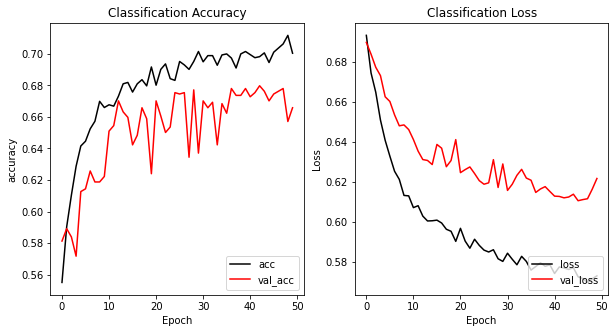

In [36]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.style.use("seaborn-bright")

ax[0].plot(history.history['accuracy'], label='acc',color="black")
ax[0].plot(history.history['val_accuracy'], label = 'val_acc',color="red")
ax[1].plot(history.history['loss'], label='loss',color="black")
ax[1].plot(history.history['val_loss'], label = 'val_loss',color="red")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].set_title('Classification Accuracy')
ax[1].set_title('Classification Loss')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
plt.savefig('present_VAE_loss.png')
plt.show()

In [38]:

#Xtest=np.array(Xtrain).reshape(1138, 7936, 1)
#Xtest=preprocessing.normalize(Xtest)
Xtest=np.asarray(Xtest).reshape(1436, 200, 1)
test_loss,test_acc = full_model.evaluate(np.asarray(Xtest),np.asarray(Ytest))
print('Test accuracy:', test_acc)
Y_pred2=full_model.predict(np.asarray(Xtest))
Ypred=np.argmax(Y_pred2, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

45/45 [==============================] - 1s 19ms/step - loss: 0.6065 - accuracy: 0.6616
Test accuracy: 0.6615598797798157
[[426 285]
 [201 524]]


In [39]:
autoencoder.save('present_VAE.h5')
full_model.save('present_VAE_classifier.h5')